# Multinomial model
this model will take details about the time and date and predict the number of spots available for a location that has multiple chargers (either a cluster or site)

the model might take the form of 

$ num_spots = linear combination of (hour , month, is_holiday, day_of_week) $

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_preprocessing import datetime_processing, userinput_processing, holiday_processing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score


In [18]:
def get_results(y_test, prediction):
    cm = confusion_matrix(y_test,prediction)
    make_classification_plot(cm)
    
    results = {'tpr': cm[1, 1]/np.sum(cm[1]),
               'fpr': cm[0,1]/np.sum(cm[0]),
               'accuracy': accuracy_score(y_test, prediction),
               'precision': precision_score(y_test, prediction, average='weighted'),
               'recall': recall_score(y_test, prediction, average='weighted'),
        'f1':f1_score(y_test,prediction, average='weighted')}
    return results

def make_classification_plot(cm):
    disp = ConfusionMatrixDisplay(cm)
    disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.show()

# 1. Make data, X, y

In [4]:
df_of = pd.read_parquet('data/ACN-API/office001/').reset_index(drop=True)
df_of = datetime_processing(df_of)
df_of = userinput_processing(df_of)
df_of = holiday_processing(df_of)
df_of.head()

,_id,userID,sessionID,stationID,spaceID,siteID,clusterID,connectionTime,disconnectTime,kWhDelivered,...,doneChargingTimeDay,userID,milesRequested,WhPerMile,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,kWhRequested,is_holiday
0,5cd1d47af9af8b68f0e96713,None,19_102_260_1633_2019-03-25 16:24:42.408146,19-102-260-1633,02,19,102,2019-03-25 16:24:42+00:00,2019-03-26 01:32:12+00:00,6.146,...,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
1,5cd1d47af9af8b68f0e96714,None,19_102_260_1634_2019-03-25 17:19:26.896309,19-102-260-1634,03,19,102,2019-03-25 17:19:27+00:00,2019-03-26 00:38:50+00:00,3.658,...,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
2,5cd1d47af9af8b68f0e96715,None,19_102_260_1640_2019-03-25 21:27:32.338192,19-102-260-1640,08,19,102,2019-03-25 21:27:32+00:00,2019-03-26 03:32:03+00:00,28.330,...,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
3,5cd1d47df9af8b68f0e96716,None,19_102_260_1640_2019-03-26 18:33:56.204855,19-102-260-1640,08,19,102,2019-03-26 18:33:56+00:00,2019-03-27 00:45:33+00:00,12.978,...,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False
4,5cd1d47ef9af8b68f0e96717,None,19_102_260_1640_2019-03-27 18:28:00.642220,19-102-260-1640,08,19,102,2019-03-27 18:28:01+00:00,2019-03-28 00:37:47+00:00,10.688,...,27.0,NaN,NaN,NaN,NaN,None,None,None,NaN,False


In [5]:
tmp = df_of.copy()
tmp.set_index('connectionTime', inplace=True)
start_date = '2019-03-25'; end_date = '2021-09-12'
tmp = tmp.sort_index().loc[start_date:end_date,:]

space_cols = tmp.spaceID.unique()
space_cols = (list(space_cols.astype('str')))

y = pd.DataFrame(index=pd.date_range(start_date,end_date, inclusive='both', freq='h', tz=0),columns=space_cols)
y[space_cols] = 1

print('there is a problem here. Some charging sessions have the EXACT same start time (see index 335)', tmp.iloc[335:337, 0:2])
print('the solution is to go through the dataframe by index number, using iloc, instead of by connection time using .loc')
disconnect_col = np.where(tmp.columns == 'disconnectTime')[0][0]
session_col = np.where(tmp.columns == 'sessionID')[0][0]
space_col = np.where(tmp.columns == 'spaceID')[0][0]

print(f'so we use the column number instead of the column name, hence why we disconnect is {disconnect_col}, session is {session_col}, and space is {space_col}')

for i in range(len(tmp)):
    start_ = tmp.index[i]
    end_ = tmp.iloc[i, disconnect_col] 
    session_ = tmp.iloc[i, session_col]
    space_ = tmp.iloc[i, space_col]
    # print(start_,'\t', end_,'\t', session_, '\t', space_)
    try:
        y.loc[start_:end_,space_] = 0
    except:
        print('bad value:')
        print(i, '\t', start_,'\t', end_,'\t', session_, '\t', space_)

there is a problem here. Some charging sessions have the EXACT same start time (see index 335)                                                 _id userID
connectionTime                                            
2019-08-15 15:19:23+00:00  5d6b110ff9af8b08b9d8bbaa   None
2019-08-15 16:45:41+00:00  5d6b110ff9af8b08b9d8bbab   None
the solution is to go through the dataframe by index number, using iloc, instead of by connection time using .loc
so we use the column number instead of the column name, hence why we disconnect is 7, session is 2, and space is 4


Text(0.5, 1.0, 'available spots over time at the office')

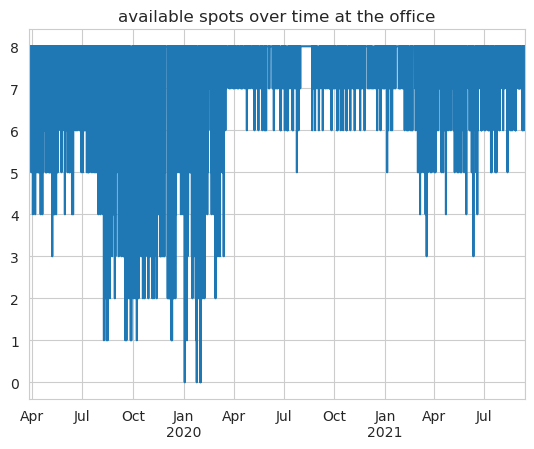

In [6]:
y.sum(axis=1).plot()
plt.title('available spots over time at the office')

In [7]:
X = pd.DataFrame(index=pd.date_range('2019-03-25','2021-09-12', inclusive='both', freq='h', tz=0),columns=['dow','hour','month'])
# X['dow'] = X.index.dt.hour
X['dow'] = X.index.dayofweek
X['hour'] = X.index.hour
X['month'] = X.index.month
X['connectionTime'] = X.index
X = holiday_processing(X).drop(columns=['connectionTime'])
X.head()

,dow,hour,month,is_holiday
2019-03-25 00:00:00+00:00,0,0,3,False
2019-03-25 01:00:00+00:00,0,1,3,False
2019-03-25 02:00:00+00:00,0,2,3,False
2019-03-25 03:00:00+00:00,0,3,3,False
2019-03-25 04:00:00+00:00,0,4,3,False


# 1.2 split data

In [8]:
train_test_cutoff_date = '2021-06-01'

In [9]:
# Create hold out test set
X_train, X_test, y_train, y_test = train_test_split(X, y.sum(axis=1), test_size = .2)
print(f'the training data has an average availability of {np.round(y_train.mean(),3)} spots available')

the training data has an average availability of 7.495 spots available


In [10]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train)
X_test_ohe = ohe.transform(X_test)

# 4. Model

In [11]:
y_test

2020-10-22 06:00:00+00:00    8
2020-12-16 16:00:00+00:00    8
2021-02-18 23:00:00+00:00    6
2019-05-15 08:00:00+00:00    8
2021-07-28 14:00:00+00:00    8
                            ..
2021-04-12 03:00:00+00:00    8
2021-08-25 10:00:00+00:00    8
2021-08-15 08:00:00+00:00    8
2021-09-11 20:00:00+00:00    8
2020-11-29 20:00:00+00:00    8
Length: 4330, dtype: int64

In [12]:

classifier = LogisticRegression(C=1e5, solver='newton-cg', multi_class='multinomial')
classifier.fit(X_train_ohe, y_train)
pred_labels = pd.Series(classifier.predict(X_test_ohe), index=X_test.index)

<Axes: >

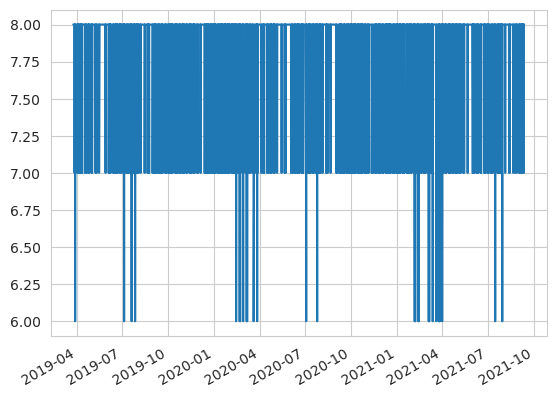

In [13]:
pred_labels.sort_index().plot()

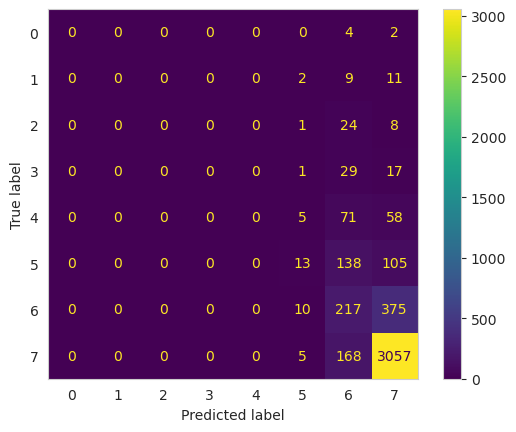

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'tpr': 0.0,
 'fpr': 0.0,
 'accuracy': 0.7591224018475751,
 'precision': 0.6941733374609264,
 'recall': 0.7591224018475751,
 'f1': 0.7176061335121939}

In [19]:
get_results(y_test, pred_labels)

In [17]:
?precision_score

In [ ]:
classifier = LogisticRegression(multi_class='multinomial', max_iter=10000)
classifier.fit(X_train_ohe, y_train)
pred_labels = pd.Series(classifier.predict(X_test_ohe), index=X_test.index)
pred_labels.sort_index().plot()

In [ ]:
C=10
classifier = LogisticRegression(C=C, penalty='l1',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000)
classifier.fit(X_train_ohe, y_train)
pred_labels = pd.Series(classifier.predict(X_test_ohe), index=X_test.index)
pred_labels.sort_index().plot()


In [ ]:
plt.plot(pred_labels.sort_index(), 'o')
plt.plot(y_test.sort_index(), '--')

# For fun, linear regression
It doesnt work well because the predictions are wrong due to
1. not descrete, it choses values like 5.5 spaces available
2. chooses values too high, like more than 8 spaces, which is impossible

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train_ohe, y_train)
pred = pd.Series(lm.predict(X_test_ohe), index=X_test.index)


In [ ]:
plt.plot(pred.sort_index(), 'o')
plt.plot(y_test.sort_index(), '--')

In [ ]:
# consider interaction terms
# https://stackoverflow.com/questions/45828964/how-to-add-interaction-term-in-python-sklearn
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
poly.fit_transform(X)